# Image Classification with MultiRasterIO

In this tutorial it is shown how to use the class ``MultiRasterIO`` to perform image classification.
We will

* extract a training dataset (see tutorial *Extract Raster Values of Pixels Overlapping with Vector Data*),
* build a model,
* classify the raster dataset with the model. 

We will run through the first two steps and focus on the last here.

In [3]:
import fnmatch
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier

from eobox import raster
from eobox import sampledata

## Extract Reference Data

In [4]:
dataset = sampledata.get_dataset("s2l1c")

src_vector = dataset["vector_file"]
burn_attribute = "pid"  # should be unique for the polygons and not contain zero
src_raster = sorted(fnmatch.filter(dataset["raster_files"], "*B0[2,3,4,8]*"))  # 10 m bands
feature_names = ["_".join(Path(src).stem.split("_")[1::]) for src in src_raster]
extraction_dir = Path("s2l1c_ref__s2l1c/s2_l1c/10m")

raster.extract(src_vector=src_vector,
                    burn_attribute=burn_attribute,
                    src_raster=src_raster,
                    dst_names=feature_names,
                    dst_dir=extraction_dir)

df_extracted = raster.load_extracted(extraction_dir)
gdf = gpd.read_file(src_vector)
df_extracted = df_extracted.merge(gdf[["pid", "cid", "comment"]], how="left", left_on="aux_vector_pid", right_on="pid")
df_extracted.head(2)

,aux_coord_y,20170216T102101_B02,20170216T102101_B03,aux_coord_x,aux_vector_pid,20170216T102101_B04,20170216T102101_B08,pid,cid,comment
0,5822035.0,1456,1072,344545.0,17,928,672,17,1,partially out; expecting: 2 - with default ras...
1,5822035.0,1392,1040,344555.0,17,928,672,17,1,partially out; expecting: 2 - with default ras...


## Build a Model

Lets train a Random Forest model with the whole reference data on four Sentinel-2 bands.

With the extracted data that can be done as follows:

In [5]:
y = df_extracted["cid"].values
X = df_extracted[feature_names].values
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Prediction of Probabilities

This section is the focus of this notebook. 
We will see show how to predict the image by using the model trained in the last section and the ``MultiRasterIO`` class.
As in the tutorial on NDVI calculation with ``MultiRasterIO`` we first setup the class instance and get a window of data for developing the prediction.

In [6]:
mr = raster.MultiRasterIO(layer_files=src_raster)
mr.block_windows()
arr = mr.get_arrays(0)
arr.shape

(64, 64, 4)

We get the data as a three dimensional array where the dimensions are (X, Y, Layers). 
However the ``predict*`` methods of a **sklearn** estimator require the features in a two dimensional array where the dimensions are (Sample = Pixel, Features = Layers).

We can use the ``PixelClassifier`` from the **s2cloudless** package or ``ImagePixelClassifier`` from the **eolearn.ml_tools** package both developed by Synergise.

If you do not have these packages installed you can simply copy and paste the ``PixelClassifier`` from the [*PixelClassifier.py* module in the **sentinel2-cloud-detector** project](https://github.com/sentinel-hub/sentinel2-cloud-detector/blob/master/s2cloudless/PixelClassifier.py) as has it been done to fill the following cell.

In [7]:
class PixelClassifier(object):
    """
    Pixel classifier extends a receptive field of a classifier over an entire image.
    The classifier's receptive field is in case of PixelClassifier a pixel (i.e, it
    has dimension of (1,1))

    Pixel classifier divides the image into individual pixels, runs classifier over
    them, and finally produces a classification mask of the same size as image.

    The classifier can be of any type as long as it has the following two methods
    implemented:
        - predict(X)
        - predict_proba(X)

    This is true for all classifiers that follow scikit-learn's API.
    The APIs of scikit-learn's objects is described
    at: http://scikit-learn.org/stable/developers/contributing.html#apis-of-scikit-learn-objects.

    :param classifier: trained classifier that will be executed over an entire image
    :type classifier: any classifier with predict(X) and predict_proba(X) methods
    """

    def __init__(self, classifier):
        self.receptive_field = (1, 1)
        self._check_classifier(classifier)
        self.classifier = classifier

    def _check_classifier(self, classifier):
        """
        Check if the classifier implements predict and predict_proba methods.
        """
        predict = getattr(classifier, "predict", None)
        if not callable(predict):
            raise ValueError('Classifier does not have a predict method!')

        predict_proba = getattr(classifier, "predict_proba", None)
        if not callable(predict_proba):
            raise ValueError('Classifier does not have a predict_proba method!')

    @staticmethod
    def extract_pixels(X):
        """ Extract pixels from array X

        :param X: Array of images to be classified.
        :type X: numpy array, shape = [n_images, n_pixels_y, n_pixels_x, n_bands]
        :return: Reshaped 2D array
        :rtype: numpy array, [n_samples*n_pixels_y*n_pixels_x,n_bands]
        :raises: ValueError is input array has wrong dimensions
        """
        if len(X.shape) != 4:
            raise ValueError('Array of input images has to be a 4-dimensional array of shape'
                             '[n_images, n_pixels_y, n_pixels_x, n_bands]')

        new_shape = (X.shape[0] * X.shape[1] * X.shape[2], X.shape[3],)
        pixels = X.reshape(new_shape)
        return pixels

    def image_predict(self, X):
        """
        Predicts class label for the entire image.

        :param X: Array of images to be classified.
        :type X: numpy array, shape = [n_images, n_pixels_y, n_pixels_x, n_bands]

        :return: raster classification map
        :rtype: numpy array, [n_samples, n_pixels_y, n_pixels_x]
        """

        pixels = self.extract_pixels(X)

        predictions = self.classifier.predict(pixels)

        return predictions.reshape(X.shape[0], X.shape[1], X.shape[2])

    def image_predict_proba(self, X):
        """
        Predicts class probabilities for the entire image.

        :param X: Array of images to be classified.
        :type X: numpy array, shape = [n_images, n_pixels_y, n_pixels_x, n_bands]

        :return: classification probability map
        :rtype: numpy array, [n_samples, n_pixels_y, n_pixels_x]
        """

        pixels = self.extract_pixels(X)

        probabilities = self.classifier.predict_proba(pixels)

        return probabilities.reshape(X.shape[0], X.shape[1], X.shape[2], probabilities.shape[1])

In the docstring we can read that the prediction methods want the data in the format [n_images, n_pixels_y, n_pixels_x, n_bands]. 
So let us expand the dimensions to fulfil the requirement and predict the array.

In [8]:
pclf = PixelClassifier(clf)
probs = pclf.image_predict_proba(np.expand_dims(arr, 0))
probs = (probs * 100).astype(np.uint8)  # lets store the probabilities as integer later
print("Shape of input array:", np.expand_dims(arr, 0).shape)
print("Shape of output arrray:", probs.shape)

Shape of input array: (1, 64, 64, 4)
Shape of output arrray: (1, 64, 64, 2)


Now we can plot the result and check if it makes sense. 
Since there is a small lake in the upper left corner of the image (for which we loaded the data) it seems to make sense.

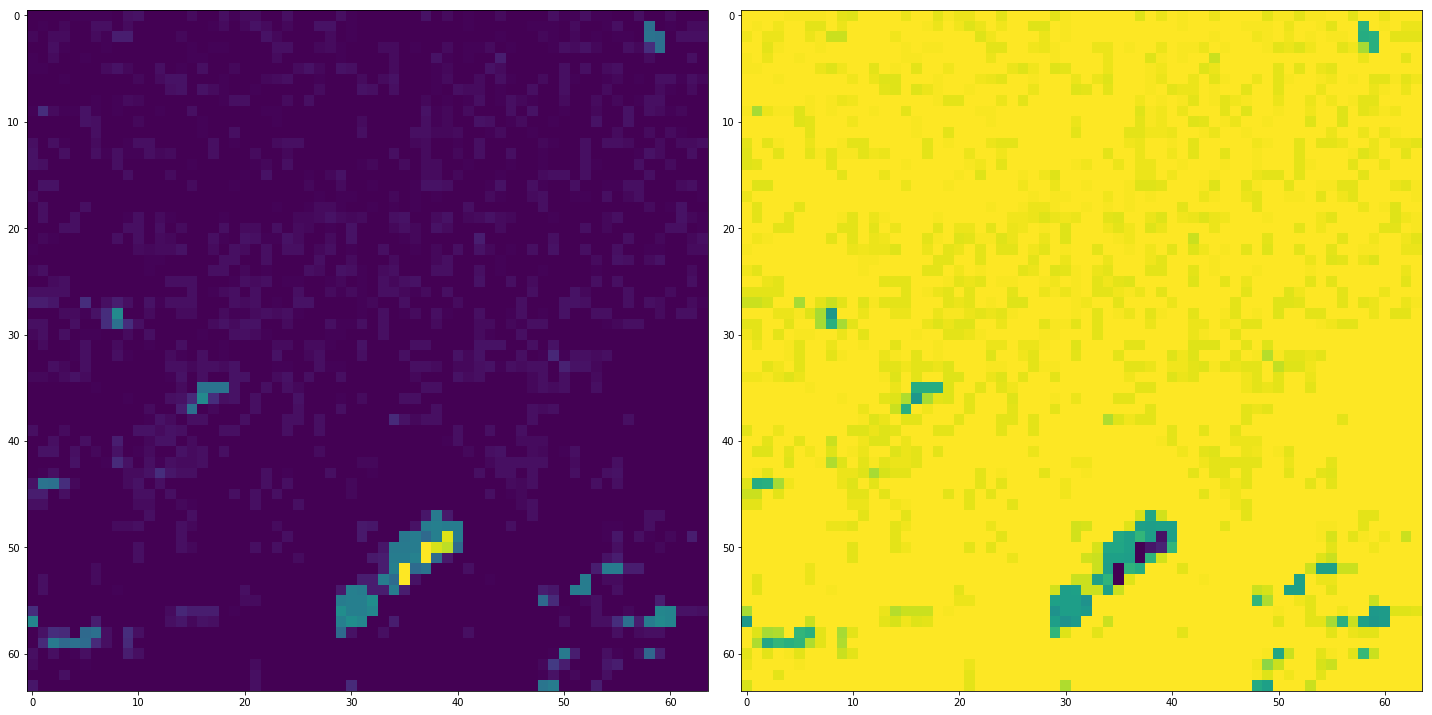

In [9]:
fig, axes = plt.subplots(1,2, figsize=(20, 10))

axes.flatten()[0].imshow(probs[0,:,:,0], vmin=0, vmax=100)
axes.flatten()[1].imshow(probs[0,:,:,1], vmin=0, vmax=100)
fig.tight_layout()

We can now wrap the code in a function and apply it on the whole raster dataset and store the probability layers to disc as follows:

In [10]:
def image_predict_proba(arr, pclf):
    """A custom function for running predict_proba of a sklearn estimator on an image."""
    import numpy as np
    probs = (pclf.image_predict_proba(np.expand_dims(arr, 0)) * 100).astype(np.uint8)
    probs = [probs[0,:,:,i] for i in range(probs.shape[3])]
    return probs

probs = image_predict_proba(arr, pclf=pclf)
print("Length of probs: ", len(probs))
print("Shape of probs[0]: ", probs[0].shape)
print("Shape of probs[1]: ", probs[1].shape)
dst_dir = Path(".").absolute() / "pclf_water_predict_proba"
prob_files = [str(dst_dir / "prob_cid1.jp2"),
              str(dst_dir / "prob_cid2.jp2")]
prob_files

Length of probs:  2
Shape of probs[0]:  (64, 64)
Shape of probs[1]:  (64, 64)


['/home/ben/Devel/Repos/eo-box/examples/raster/pclf_water_predict_proba/prob_cid1.jp2',
 '/home/ben/Devel/Repos/eo-box/examples/raster/pclf_water_predict_proba/prob_cid2.jp2']

In [11]:
exit_code = mr.apply_and_save(dst_files=prob_files,
                              func=image_predict_proba,
                              pclf=pclf)

## Class, Probability and Confidence Layers

Often we want as an outcome the class or prediction layer, probability layers and confidence layers.
We can extend the ``image_predict_proba`` above as follows:

In [12]:
def image_predict(arr, pclf):
    probs = (pclf.image_predict_proba(np.expand_dims(arr, 0)) * 100).astype(np.uint8)[0,:,:,:]
    # get the prediction image (class ids)
    pred_idx = probs.argmax(axis=2)
    pred = np.zeros_like(pred_idx).astype(np.uint8)
    for i in range(probs.shape[2]):
        pred[pred_idx==i] = pclf.classifier.classes_[i]
    # get reliability layers (maximum probability and margin, i.e. maximum probability minus second highest probability)
    probs_sorted = np.sort(probs, axis=2)
    max_prob = probs_sorted[:,:,probs_sorted.shape[2]-1]
    margin = probs_sorted[:,:,probs_sorted.shape[2]-1] - probs_sorted[:,:,probs_sorted.shape[2]-2]
    out_layers = [probs[:,:,i] for i in range(probs.shape[2])]
    out_layers.append(pred)
    out_layers.append(max_prob)
    out_layers.append(margin)
    return out_layers

out_layers = image_predict(arr, pclf=pclf)

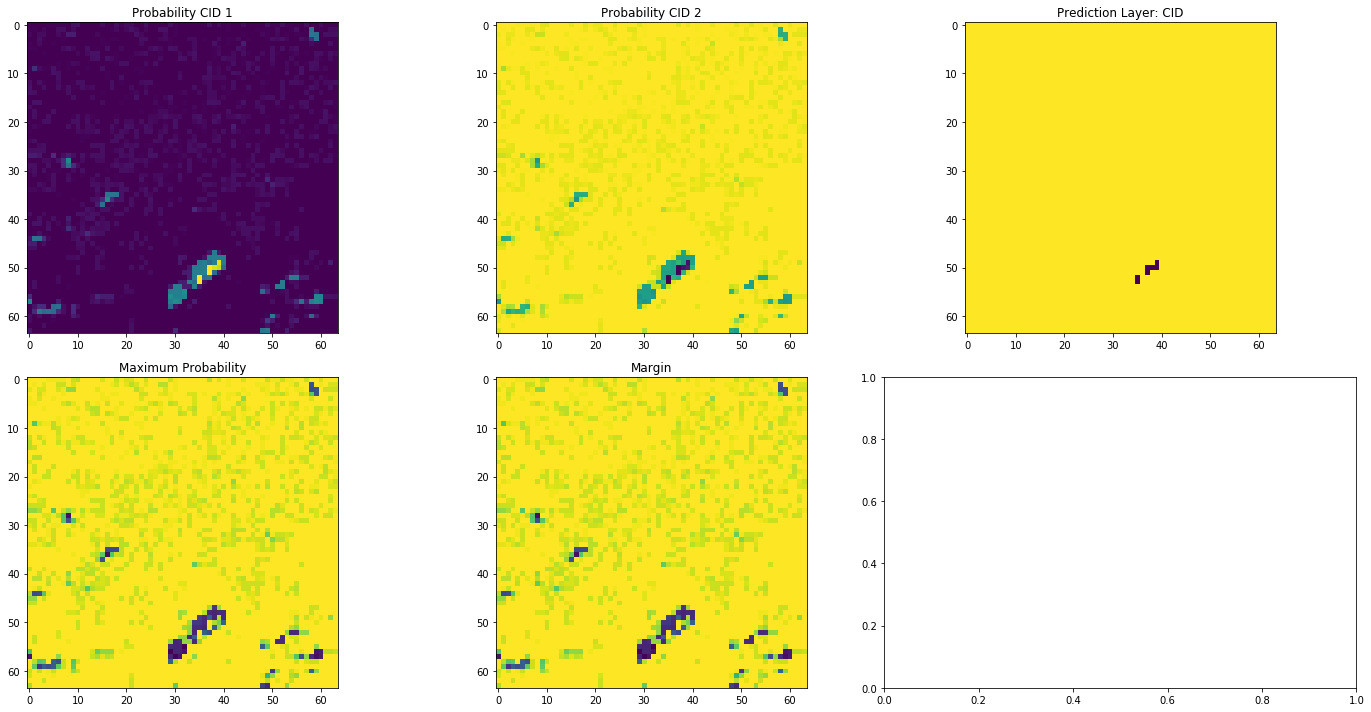

In [13]:
fig, axes = plt.subplots(2,3, figsize=(20, 10))

axes.flatten()[0].imshow(out_layers[0])
axes.flatten()[0].set_title("Probability CID 1")

axes.flatten()[1].imshow(out_layers[1])
axes.flatten()[1].set_title("Probability CID 2")

axes.flatten()[2].imshow(out_layers[2])
axes.flatten()[2].set_title("Prediction Layer: CID")

axes.flatten()[3].imshow(out_layers[3])
axes.flatten()[3].set_title("Maximum Probability")

axes.flatten()[4].imshow(out_layers[3])
axes.flatten()[4].set_title("Margin")

axes.flatten()[5] = None

fig.tight_layout()

And for the whole image:

In [14]:
out_layer_filenames = [str(dst_dir / "prob_cid1.jp2"),
                       str(dst_dir / "prob_cid2.jp2"),
                       str(dst_dir / "predictions.jp2"),
                       str(dst_dir / "maximum_probability.jp2"),
                       str(dst_dir / "margin.jp2"),
                       ]

exit_code = mr.apply_and_save(dst_files=out_layer_filenames,
                              func=image_predict,
                              pclf=pclf)

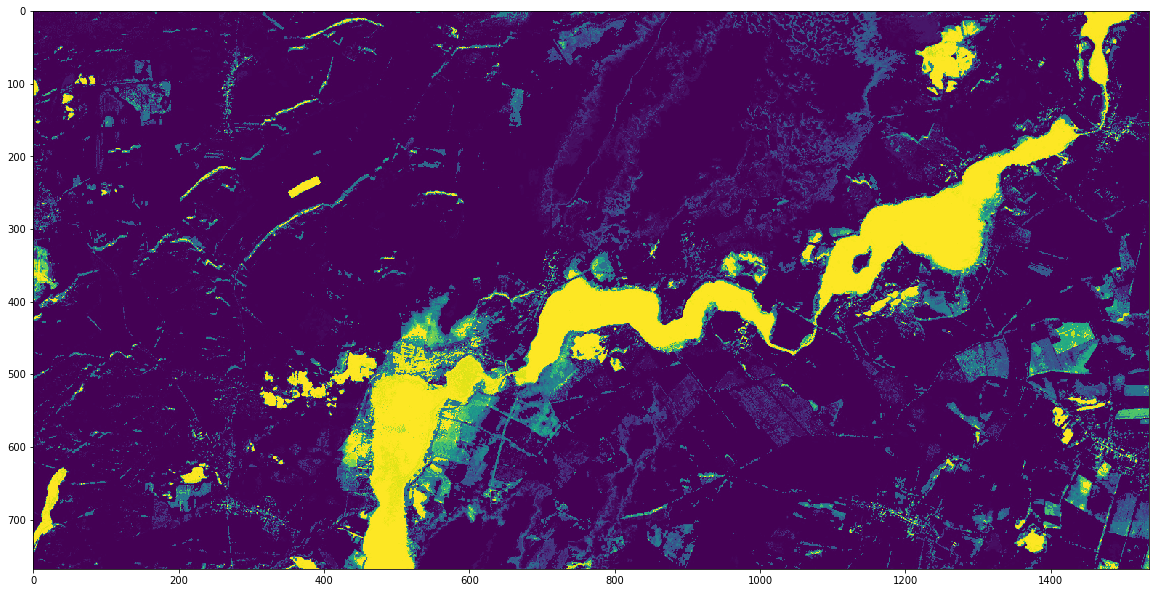

In [18]:
import rasterio
fig, ax = plt.subplots(1,1, figsize=(20, 20))
with rasterio.open(str(dst_dir / "prob_cid1.jp2")) as prob_cid1:
    arr = prob_cid1.read()
    ax.imshow(arr[0,:,:], vmin=0, vmax=100)